<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/InfoDengue_vs_Clade_SP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geobr
!pip install unidecode
!pip install rapidfuzz

In [ ]:
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import requests
import plotly.graph_objects as go

import time
from tqdm import tqdm

from geobr import read_municipality, read_state
import geopandas as gpd
import gc

from sklearn.preprocessing import StandardScaler
import seaborn as sns
from unidecode import unidecode

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Clade Data

In [ ]:
path = r"/content/drive/MyDrive/GISAID/nextclade_sp_all.xlsx"

frames = []
xls = pd.ExcelFile(path)
for sh in xls.sheet_names:
    df = pd.read_excel(path, sheet_name=sh, dtype=str)
    df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
    df['sheet'] = sh
    frames.append(df)

clade_data = pd.concat(frames, ignore_index=True, sort=False)
clade_data.head()

,index,seqName,clade,qc.overallScore,qc.overallStatus,totalSubstitutions,totalDeletions,totalInsertions,totalFrameShifts,totalMissing,...,qc.stopCodons.stopCodons,qc.stopCodons.totalStopCodons,qc.stopCodons.score,qc.stopCodons.status,totalPcrPrimerChanges,pcrPrimerChanges,failedCdses,warnings,errors,sheet
0,0,hDenV1/Brazil/SP-IAL-NS10908/2022|EPI_ISL_1490...,1V_A,28.698980,good,828,0,0,0,39,...,NaN,0,0,good,0,NaN,NaN,NaN,NaN,...unity_v-gen-lab_dengue_denv1
1,1,hDenV1/Brazil/SP-IAL-NS10928/2022|EPI_ISL_1490...,1V_E.1,0,good,853,0,0,0,2,...,NaN,0,0,good,0,NaN,NaN,NaN,NaN,...unity_v-gen-lab_dengue_denv1
2,2,hDenV1/Brazil/SP-IAL-NS10949/2022|EPI_ISL_1490...,1V_E.1,0,good,850,0,0,0,43,...,NaN,0,0,good,0,NaN,NaN,NaN,NaN,...unity_v-gen-lab_dengue_denv1
3,3,hDenV1/Brazil/SP-IAL-NS10957/2022|EPI_ISL_1490...,1V_E.1,0,good,852,0,0,0,9,...,NaN,0,0,good,0,NaN,NaN,NaN,NaN,...unity_v-gen-lab_dengue_denv1
4,4,hDenV1/Brazil/SP-IAL-NS10973/2022|EPI_ISL_1490...,1V_E.1,0,good,835,0,0,0,33,...,NaN,0,0,good,0,NaN,NaN,NaN,NaN,...unity_v-gen-lab_dengue_denv1


In [ ]:
clade_data2 = clade_data[['seqName','clade']].copy()
clade_data2['Virus name'] = clade_data2['seqName'].str.split('|EPI_', n=1, regex=False).str[0]
clade_data2

,seqName,clade,Virus name
0,hDenV1/Brazil/SP-IAL-NS10908/2022|EPI_ISL_1490...,1V_A,hDenV1/Brazil/SP-IAL-NS10908/2022
1,hDenV1/Brazil/SP-IAL-NS10928/2022|EPI_ISL_1490...,1V_E.1,hDenV1/Brazil/SP-IAL-NS10928/2022
2,hDenV1/Brazil/SP-IAL-NS10949/2022|EPI_ISL_1490...,1V_E.1,hDenV1/Brazil/SP-IAL-NS10949/2022
3,hDenV1/Brazil/SP-IAL-NS10957/2022|EPI_ISL_1490...,1V_E.1,hDenV1/Brazil/SP-IAL-NS10957/2022
4,hDenV1/Brazil/SP-IAL-NS10973/2022|EPI_ISL_1490...,1V_E.1,hDenV1/Brazil/SP-IAL-NS10973/2022
...,...,...,...
1410,hDenV4/Brazil/SP-USP-08ACAC/un|EPI_ISL_1756946...,4II_B.1.1,hDenV4/Brazil/SP-USP-08ACAC/un
1411,hDenV4/Brazil/SP-USP-JCBP/un|EPI_ISL_17569464|...,4II_B.1.1,hDenV4/Brazil/SP-USP-JCBP/un
1412,hDenV4/Brazil/SP-LEIAL4792/2025|EPI_ISL_198148...,4II_B.1.3,hDenV4/Brazil/SP-LEIAL4792/2025
1413,hDenV4/Brazil/SP-LEIAL4793/2025|EPI_ISL_198148...,4II_B.1.3,hDenV4/Brazil/SP-LEIAL4793/2025


## GISAID Data

In [ ]:
sero_all = pd.read_csv('/content/drive/MyDrive/GISAID/gisaid_arbo_2025_09_23_14_sp.tsv', sep='\t')
location_split = sero_all['Location'].str.split(' / ', expand=True)
location_split.columns = ['Continent', 'Country', 'State', 'City']
sero_all = pd.concat([sero_all, location_split], axis=1)

sero_all = sero_all[['Virus name', 'Serotype', 'Genotype','Collection date', 'City']]

sero_all['ym'] = pd.to_datetime(sero_all['Collection date'], errors='coerce').dt.strftime('%Y-%m')
sero_all.head(3)

,Virus name,Serotype,Genotype,Collection date,City,ym
0,hDenV2/Brazil/SP-IAL-NS10939/2022,DENV2,II,2022-01-30,Piracicaba,2022-01
1,hDenV2/Brazil/SP-IAL-NS11015/2022,DENV2,II,2022-02-05,Piracicaba,2022-02
2,hDenV2/Brazil/SP-IAL-NS11331/2022,DENV2,III,2022-03-17,Tremembe,2022-03


In [ ]:
# Check Nan
sero_all.isna().sum()

,0
Virus name,0
Serotype,0
Genotype,0
Collection date,0
City,353
ym,15


In [ ]:
# Rename city with NaN as no-name
# sero_all['City'] = sero_all['City'].fillna("no-name")
sero_all = sero_all.dropna(subset=['City'])
# Check the data without date
sero_all[sero_all['ym'].isna()]

,Virus name,Serotype,Genotype,Collection date,City,ym
158,hDenV3/Brazil/SP-FAMERP-06-157/un,DENV3,Outgroup,unknown,Sao Jose do Rio Preto,NaN


In [ ]:
# Drop information without month data and unknown (because aggregate data to yearly is too coarse)
sero_all = sero_all.dropna(subset=['ym'])
sero_all[sero_all['ym'].isna()]

,Virus name,Serotype,Genotype,Collection date,City,ym


In [ ]:
print("the data starts from",sero_all['ym'].min(), 'to', sero_all['ym'].max())

the data starts from 2022-01 to 2025-07


In [ ]:
sero_all

,Virus name,Serotype,Genotype,Collection date,City,ym
0,hDenV2/Brazil/SP-IAL-NS10939/2022,DENV2,II,2022-01-30,Piracicaba,2022-01
1,hDenV2/Brazil/SP-IAL-NS11015/2022,DENV2,II,2022-02-05,Piracicaba,2022-02
2,hDenV2/Brazil/SP-IAL-NS11331/2022,DENV2,III,2022-03-17,Tremembe,2022-03
3,hDenV2/Brazil/SP-IAL-NS11353/2022,DENV2,III,2022-03-11,Piracicaba,2022-03
4,hDenV2/Brazil/SP-IAL-NS11354/2022,DENV2,II,2022-03-14,Piracicaba,2022-03
...,...,...,...,...,...,...
1400,hDenV3/Brazil/SP-LEIAL6417/2025,DENV3,III,2025-07-16,Santos,2025-07
1401,hDenV2/Brazil/SP-LEIAL6418/2025,DENV2,II,2025-07-26,Peruibe,2025-07
1402,hDenV2/Brazil/SP-LEIAL6419/2025,DENV2,II,2025-07-28,Orlandia,2025-07
1403,hDenV2/Brazil/SP-LEIAL6420/2025,DENV2,II,2025-07-30,Piracicaba,2025-07


## Merge Clade and GISAID

In [ ]:
sero1 = pd.merge(clade_data2[['Virus name', 'clade']], sero_all, on=["Virus name"], how="right")
sero1.head(5)

,Virus name,clade,Serotype,Genotype,Collection date,City,ym
0,hDenV2/Brazil/SP-IAL-NS10939/2022,2II_F.1.1.2,DENV2,II,2022-01-30,Piracicaba,2022-01
1,hDenV2/Brazil/SP-IAL-NS11015/2022,2II_F.1.1.2,DENV2,II,2022-02-05,Piracicaba,2022-02
2,hDenV2/Brazil/SP-IAL-NS11331/2022,2III_C.1.1,DENV2,III,2022-03-17,Tremembe,2022-03
3,hDenV2/Brazil/SP-IAL-NS11353/2022,2III_C.1.1,DENV2,III,2022-03-11,Piracicaba,2022-03
4,hDenV2/Brazil/SP-IAL-NS11354/2022,2II_F.1.1.2,DENV2,II,2022-03-14,Piracicaba,2022-03


In [ ]:
sero1.isna().sum()

,0
Virus name,0
clade,0
Serotype,0
Genotype,0
Collection date,0
City,0
ym,0


In [ ]:
sero1['clade'].unique()

array(['2II_F.1.1.2', '2III_C.1.1', '1V_E.1', '1V_A', '1V_D.1.1', '1V_F',
       '3III_B.3.2', '1V_E', '4II_B.1.3'], dtype=object)

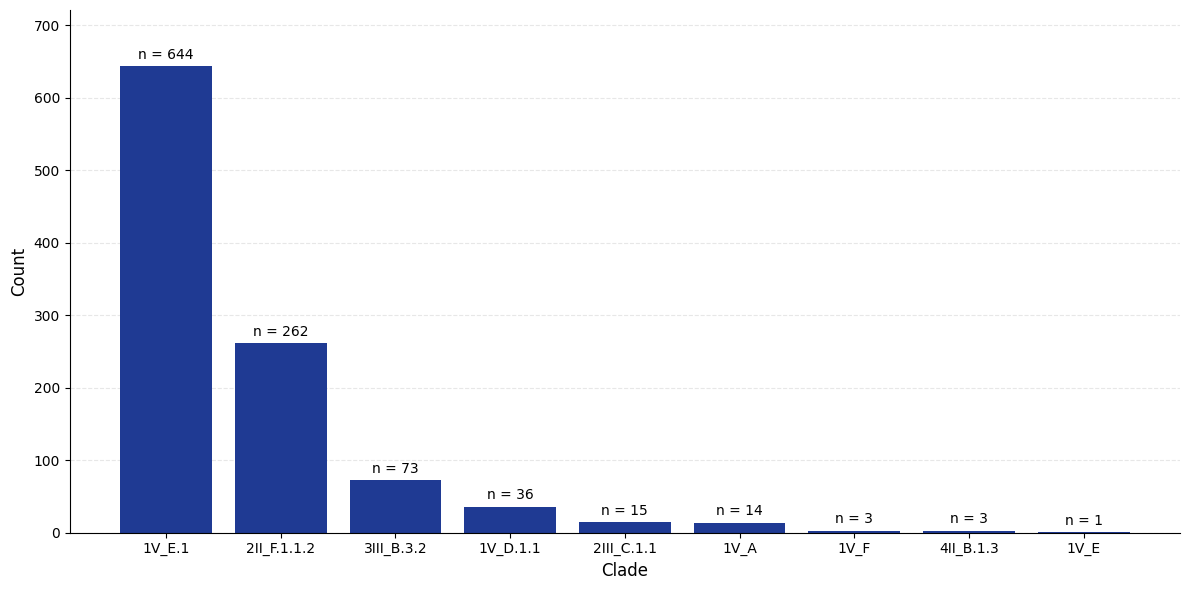

In [ ]:
clade_counts = (sero1.groupby('clade')
                  .size()
                  .sort_values(ascending=False)
                  .rename('count')
                  .reset_index())


w = max(12, 0.7 * len(clade_counts))
fig, ax = plt.subplots(figsize=(w, 6))

bars = ax.bar(clade_counts['clade'], clade_counts['count'], color='#1f3a93')


ax.bar_label(bars,
             labels=[f"n = {v:,}" for v in clade_counts['count']],
             padding=3, fontsize=10)

# ax.set_title("Clade Counts – Sao Paulo", fontsize=14, weight='bold', name='Liberation Mono')
ax.set_xlabel("Clade", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis='x', rotation=0)
plt.margins(y=0.12)
plt.tight_layout()
plt.show()


In [ ]:
['1V_A', '2III_C.1.1', '1V_D.1.1']

['1V_A', '2III_C.1.1', '1V_D.1.1']

## Get IBGE

In [ ]:
def norm_name(s):
    s = str(s).strip().lower()
    s = s.replace("''", "'")
    s = s.replace(" d'oeste", " do oeste")
    s = unidecode(s)
    for ch in "-'.,":
        s = s.replace(ch, ' ')
    return ' '.join(s.split())

In [ ]:
extra = {
    "santa barbara d'oeste": "santa barbara do oeste",
    "santa barbara d oeste": "santa barbara do oeste",
    "lencoes paulista": "lencois paulista",
    "lencois paulista": "lencois paulista",
    "franco da rocha": "franco da rocha",
    "mogi guacu": "mogi guacu",
    "mogi mirim": "mogi mirim",
    "guaruja": "guaruja",
    "jau": "jau",
    "itanhaem": "itanhaem",
    "ribeirao preto": "ribeirao preto",
    "sao jose dos campos": "sao jose dos campos",
    "sao jose do rio preto": "sao jose do rio preto",
    "sao caetano do sul": "sao caetano do sul",
    "santo andre": "santo andre",
    "sao paulo": "sao paulo",
    "sao luis do paraitinga": "sao luis do paraitinga",
}

In [ ]:
def attach_ibge(sero_df, ref_df, city_col="City", out_col="IBGE"):

    ref_df = ref_df.copy()
    ref_df = ref_df.rename(columns=str.lower)
    ref_df["name_key"] = ref_df["name"].apply(norm_name)

    sero_df = sero_df.copy()
    sero_df["_city_norm"] = sero_df[city_col].astype(str).apply(norm_name)
    sero_df["_city_key"]  = sero_df["_city_norm"].map(extra).fillna(sero_df["_city_norm"])

    merged = sero_df.merge(ref_df[["name_key", "ibge_code", "name"]], left_on="_city_key", right_on="name_key", how="left")

    merged[out_col] = merged["ibge_code"]
    merged = merged.drop(columns=["_city_norm", "_city_key", "name_key", "ibge_code"])

    return merged

In [ ]:
# take ibge data
mun = read_municipality(year=2020)
mun_sp = mun[mun['code_state'] == 35].copy()

ref_sp = mun_sp[['name_muni','code_muni']].drop_duplicates()
ref_sp = ref_sp.rename(columns={'name_muni':'name', 'code_muni':'ibge_code'})
ref_sp['ibge_code'] = ref_sp['ibge_code'].astype(int).astype(str)

ref_sp.head()

,name,ibge_code
3267,Adamantina,3500105
3268,Adolfo,3500204
3269,Aguaí,3500303
3270,Águas Da Prata,3500402
3271,Águas De Lindóia,3500501


In [ ]:
sero1_ibge = attach_ibge(sero1, ref_sp)
sero1_ibge.loc[sero1_ibge['City'] == 'Sao Luis do Paraitinga', 'IBGE'] = 3550506 # Manually fix

In [ ]:
sero1_ibge.head(3)

,Virus name,clade,Serotype,Genotype,Collection date,City,ym,name,IBGE
0,hDenV2/Brazil/SP-IAL-NS10939/2022,2II_F.1.1.2,DENV2,II,2022-01-30,Piracicaba,2022-01,Piracicaba,3538709
1,hDenV2/Brazil/SP-IAL-NS11015/2022,2II_F.1.1.2,DENV2,II,2022-02-05,Piracicaba,2022-02,Piracicaba,3538709
2,hDenV2/Brazil/SP-IAL-NS11331/2022,2III_C.1.1,DENV2,III,2022-03-17,Tremembe,2022-03,Tremembé,3554805


In [ ]:
# ## Take the ibge data of the GISAiD data and export
# gcode = sero1_ibge['IBGE'].dropna().unique()
# gcode_df = pd.DataFrame({'ibge': gcode})

# out_dir = "/content/drive/MyDrive/GISAID"
# out_path = f"{out_dir}/sp_gisaid_geocode.csv"
# gcode_df.to_csv(out_path, index=False)

In [ ]:
sero1_ibge.isna().sum()

,0
Virus name,0
clade,0
Serotype,0
Genotype,0
Collection date,0
City,0
ym,0
name,3
IBGE,2


In [ ]:
# sero1_ibge = sero1_ibge.copy()

# sero1_ibge['Collection date'] = pd.to_datetime(sero1_ibge['Collection date'], errors='coerce')
# sero1_ibge = sero1_ibge.dropna(subset=['Collection date', 'clade'])           # keep only valid rows
# sero1_ibge['month'] = sero1_ibge['Collection date'].values.astype('datetime64[M]')

# sero_m = (sero1_ibge.groupby(['month','clade'], as_index=False)
#                        .size()
#                        .rename(columns={'size':'n'}))

# sero_mw = (sero_m.pivot(index='month', columns='clade', values='n')
#                    .fillna(0)
#                    .astype(int)
#                    .sort_index())

# sero_mw.head(3)

In [ ]:
# # Check if the time step are complete (all months exists)
# full = pd.date_range(sero_mw.index.min(), sero_mw.index.max(), freq='MS')

# missing_months = full.difference(sero_mw.index)
# is_complete = len(missing_months) == 0

# print(f"Complete monthly series: {is_complete}")
# if not is_complete:
#     print("Missing months:", missing_months.strftime('%Y-%m').tolist())

# ## Fill missing months and recheck
# sero_mw = sero_mw.reindex(full, fill_value=0)
# sero_mw.index.name = 'month'

# missing_months = full.difference(sero_mw.index)
# is_complete = len(missing_months) == 0

# print(f"Complete monthly series: {is_complete}")
# if not is_complete:
#     print("Missing months:", missing_months.strftime('%Y-%m').tolist())

In [ ]:
# fig, ax = plt.subplots(figsize=(16, 4))
# sero_mw.plot(kind="bar", stacked=True, ax=ax)

# ax.set_xlabel("Month")
# ax.set_ylabel("Number of sequences")
# ax.set_title("Weekly number of sequences by clade")

# ax.set_xticks(range(0, len(sero_mw), 4))
# ax.set_xticklabels(
#     sero_mw.index[::4].strftime("%Y-%m-%d"),
#     rotation=45, ha="right")

# plt.tight_layout()
# plt.show()

## Import the MEM Results

In [ ]:
mem_res = pd.read_csv('/content/drive/MyDrive/GISAID/MEM_classification_SP.csv')
mem_res = mem_res[mem_res['data_iniSE'] >= '2022-01-01'] # Take only 2022 onwards to match the period of GISAID dataset
mem_res.head(5)

,data_iniSE,casos,pop,nivel,ibge,rate_pop,week,season,season_start,t_in_season,mem_status
596,2022-01-02,2,35111,1,3500105,5.696221,52,2022,2021-08-01,23,endemic
597,2022-01-09,6,35111,1,3500105,17.088662,1,2022,2021-08-01,24,endemic
598,2022-01-16,7,35111,2,3500105,19.936772,2,2022,2021-08-01,25,endemic
599,2022-01-23,3,35111,2,3500105,8.544331,3,2022,2021-08-01,26,endemic
600,2022-01-30,7,35111,2,3500105,19.936772,4,2022,2021-08-01,27,endemic


## Filter the GISAID Data Municipalities given the MEM data

In [ ]:
gcode_mem = mem_res["ibge"].astype(str).unique()
gcode_mem.dtype

dtype('O')

In [ ]:
sero1_ibge['IBGE'] = sero1_ibge['IBGE'].astype(str)
sero1_ibge = sero1_ibge[sero1_ibge['IBGE'].isin(gcode_mem)]

In [ ]:
print("Check number of municipalities is correct:", len(gcode_mem) == len(sero1_ibge['IBGE'].unique()))

Check number of municipalities is correct: True


## Test weekly only for the whole state

In [ ]:
# sero_ibge_spt = sero1_ibge[sero1_ibge['IBGE'] == '3550308'].copy()
sero_ibge_spt = sero1_ibge.copy()
sero_ibge_spt["Collection date"] = pd.to_datetime(sero_ibge_spt["Collection date"])

sero_ibge_spt["week"] = (sero_ibge_spt["Collection date"].dt.to_period("W-SUN").dt.end_time.dt.normalize())

wide_week = (sero_ibge_spt.groupby(["week", "clade"])
             .size()
             .unstack(fill_value=0)
             .sort_index())

start = wide_week.index.min()
end   = wide_week.index.max()

full_weeks = pd.date_range(start=start, end=end, freq="W-SUN")  # now matches

wide_week_full = wide_week.reindex(full_weeks, fill_value=0).sort_index()
wide_week_full.index.name = "week"
wide_week_full

clade,1V_A,1V_D.1.1,1V_E,1V_E.1,1V_F,2III_C.1.1,2II_F.1.1.2,3III_B.3.2,4II_B.1.3
week,,,,,,,,,
2022-01-16,0,0,0,3,0,0,0,0,0
2022-01-23,0,0,0,5,0,0,0,0,0
2022-01-30,0,0,0,3,0,0,1,0,0
2022-02-06,0,0,0,9,0,0,1,0,0
2022-02-13,0,0,0,13,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2025-07-06,0,0,0,0,0,0,5,0,0
2025-07-13,0,0,0,0,0,0,1,0,0
2025-07-20,0,0,0,0,0,0,2,1,0


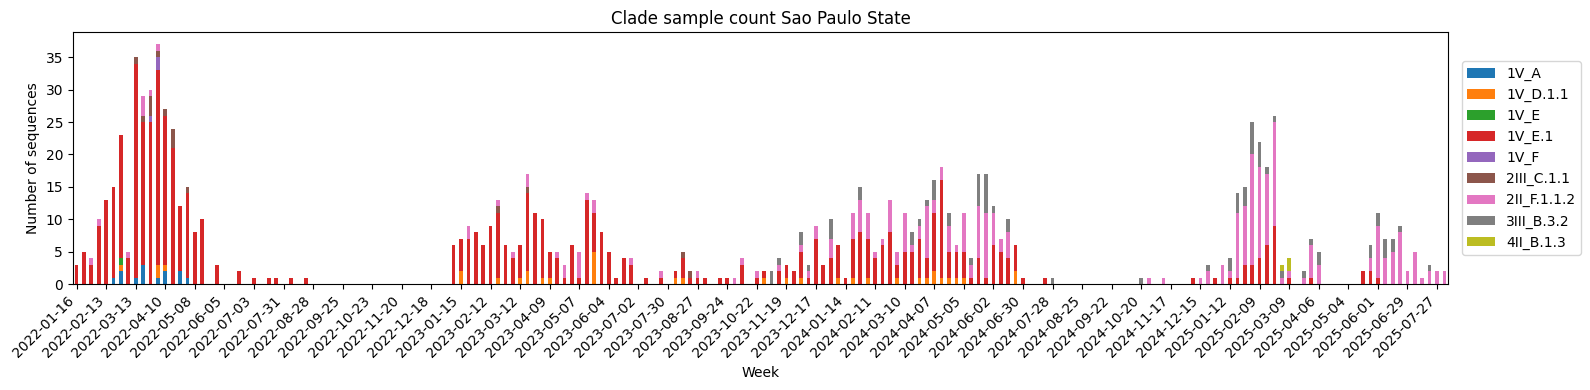

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
wide_week_full.plot(kind="bar", stacked=True, ax=ax)

ax.set_xlabel("Week")
ax.set_ylabel("Number of sequences")
ax.set_title("Clade sample count Sao Paulo State")

ax.set_xticks(range(0, len(wide_week_full), 4))
ax.set_xticklabels(
    wide_week_full.index[::4].strftime("%Y-%m-%d"),
    rotation=45, ha="right"
)

# put legend outside on the right
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,
          loc="center left",
          bbox_to_anchor=(1.01, 0.5),
          borderaxespad=0.)

plt.tight_layout()
plt.show()


## Aggregate all the Municipalities in the MEM Data

In [ ]:
wide_mem = (mem_res
    .groupby(["data_iniSE", "mem_status"])["rate_pop"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename_axis(None, axis=1)
)

wide_mem.head()

,data_iniSE,endemic,outbreak
0,2022-01-02,2245.858600,3528.808100
1,2022-01-09,2084.310263,3849.041216
2,2022-01-16,1777.852585,5535.716769
3,2022-01-23,1501.081310,6495.599241
4,2022-01-30,1458.007546,7180.980894


In [ ]:
def plot_clades_otb(
        wide_week_full,
        wide_mem,
        date_col="data_iniSE",
        value_col="outbreak",
        location_label="Sao Paulo State",
        figsize=(20, 5)
    ):

    # copy so we don't modify the originals
    ww = wide_week_full.copy()
    wm = wide_mem.copy()

    # ensure datetime alignment
    ww.index = pd.to_datetime(ww.index)
    wm[date_col] = pd.to_datetime(wm[date_col])

    # build outbreak time series aligned to clade weeks
    outbreak_ts = (
        wm
        .set_index(date_col)[value_col]
        .reindex(ww.index)
        .fillna(0)
    )

    # x positions used by bar plot
    x = np.arange(len(ww))

    fig, ax = plt.subplots(figsize=figsize)

    # stacked bars for clades
    ww.plot(kind="bar", stacked=True, ax=ax, alpha=0.7)

    ax.set_xlabel("Week")
    ax.set_ylabel("Number of sequences")
    ax.set_title(f"Clade and Outbreak Numbers {location_label}")

    # ticks: numeric positions, labels from dates
    ax.set_xticks(x[::4])
    ax.set_xticklabels(
        ww.index[::4].strftime("%Y-%m-%d"),
        rotation=45, ha="right"
    )

    # line on second y-axis
    ax2 = ax.twinx()
    line_label = value_col.replace("_", " ").title()
    line, = ax2.plot(
        x,
        outbreak_ts.values,
        linewidth=2,
        marker="o",
        markersize=3,
        label=line_label
    )
    ax2.set_ylabel("Number of outbreaks (aggregated)")

    # combine legends
    handles1, labels1 = ax.get_legend_handles_labels()
    handles = handles1 + [line]
    labels  = labels1 + [line_label]

    ax.legend(
        handles, labels,
        loc="center left",
        bbox_to_anchor=(1.06, 0.5),
        borderaxespad=0.,
    )

    plt.tight_layout()
    plt.show()


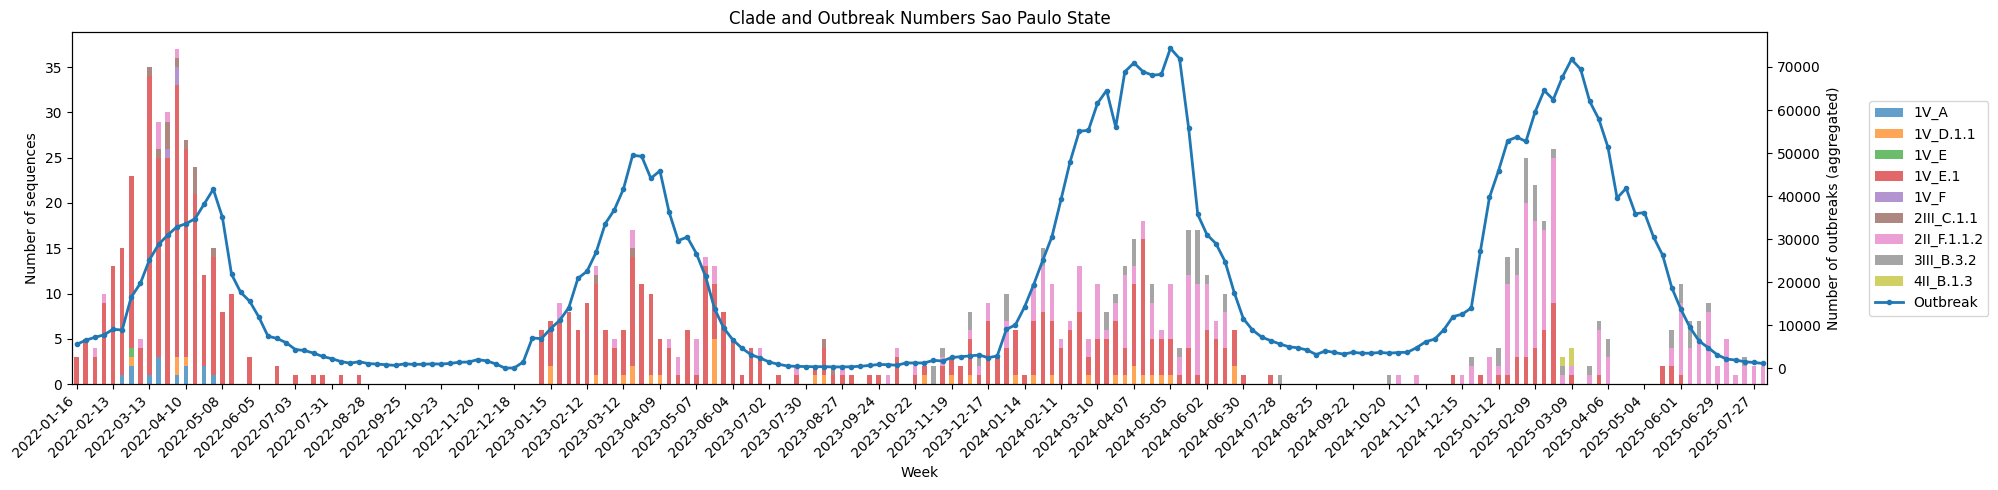

In [ ]:
# using counts
plot_clades_otb(wide_week_full, wide_mem,
                        value_col="outbreak",
                        location_label="Sao Paulo State")

## Make interpolation for short gaps
If there are short gaps of 1 - 3 weeks where no clades data exists, fill the gaps via linear interpolation

In [ ]:
def intp(df, max_gap=3):

    out = df.copy()
    zero = (out.sum(axis=1) == 0)
    grp = (zero != zero.shift(fill_value=False)).cumsum()
    run_len = zero.groupby(grp).transform("sum")
    mask = zero & (run_len <= max_gap)

    out[mask] = np.nan
    out = out.interpolate(axis=0)

    return out

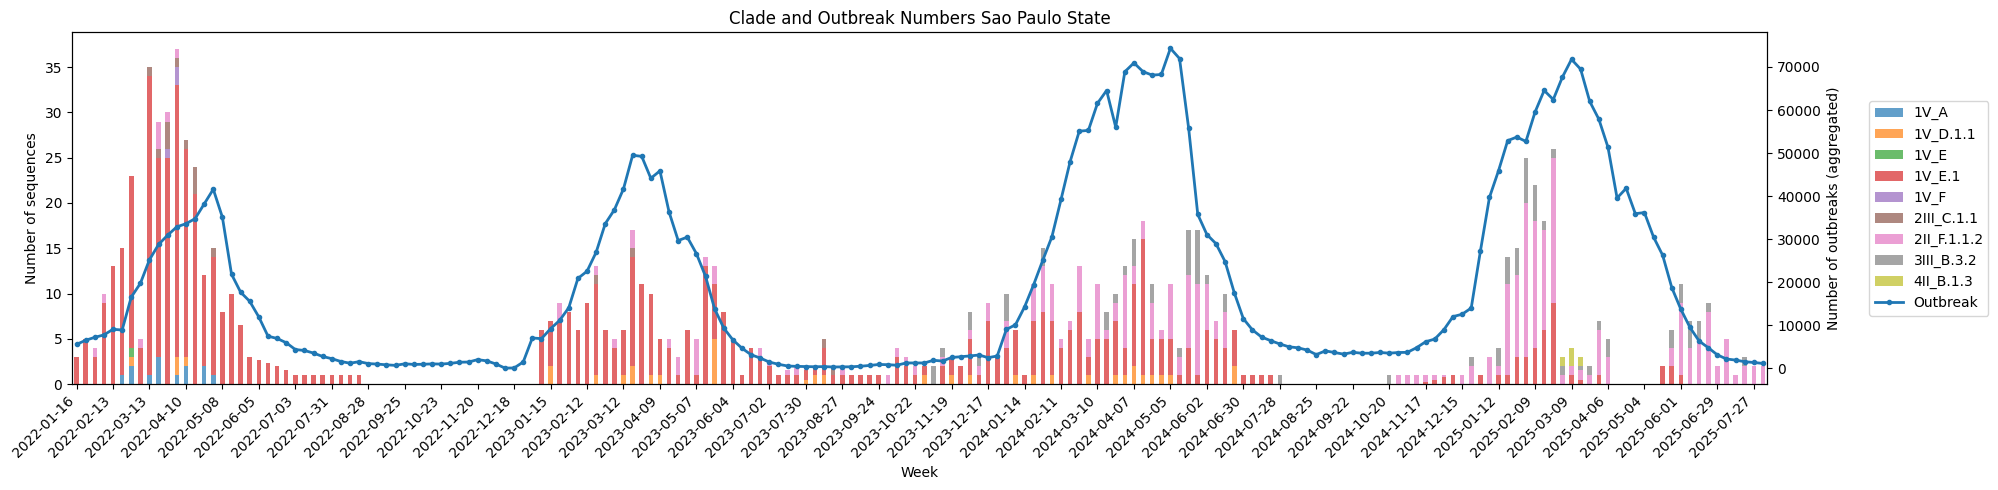

In [ ]:
# using counts
w_intp = intp(wide_week_full)
plot_clades_otb(w_intp, wide_mem,
                        value_col="outbreak",
                        location_label="Sao Paulo State")

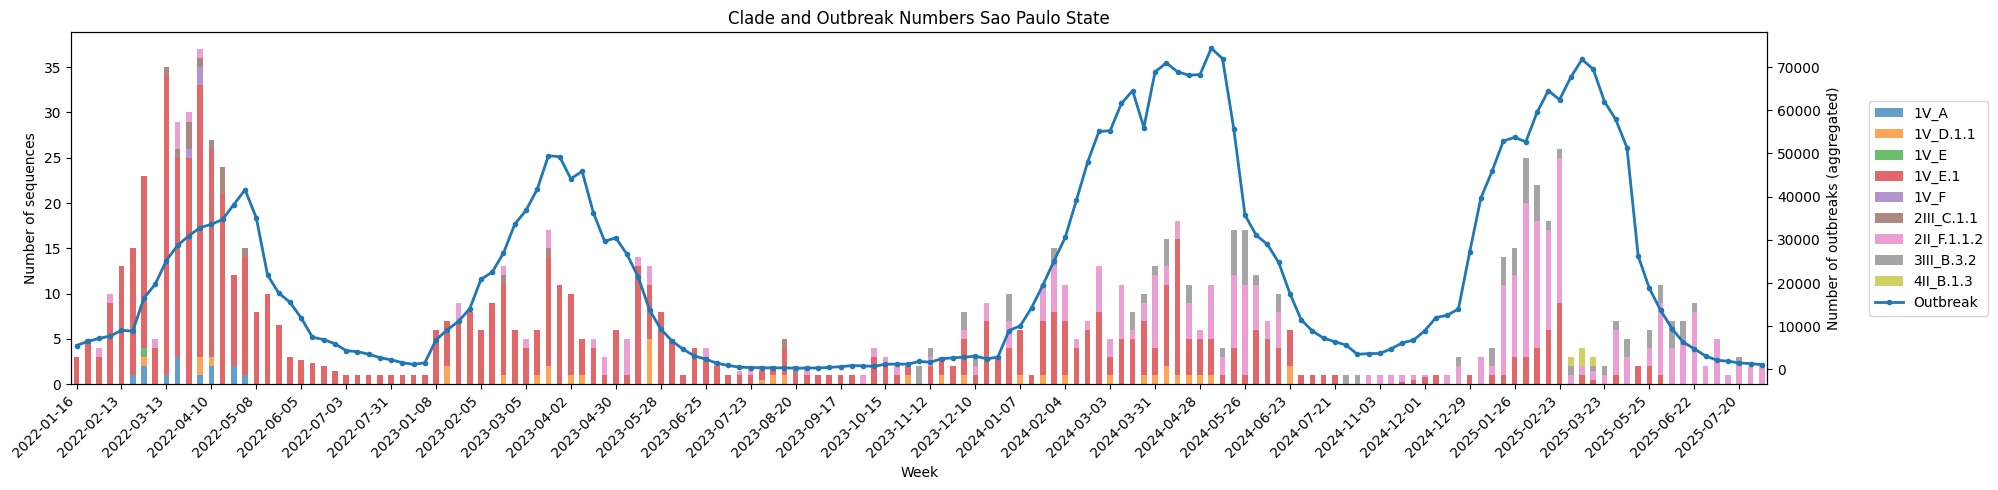

In [ ]:
mask = w_intp.sum(axis=1) > 0
w_intp2 = w_intp[mask].copy()

# using counts
plot_clades_otb(w_intp2, wide_mem,
                        value_col="outbreak",
                        location_label="Sao Paulo State")

## Take percentage proportion and find the expected clade counts from MEM output

In [ ]:
w_intp_perc = w_intp.div(w_intp.sum(axis=1), axis=0)

# Drop the rows with no clade info
mask = w_intp_perc.sum(axis=1) > 0
w_intp_perc = w_intp_perc[mask].copy()

w_intp_perc.columns.name = None
w_intp_perc = w_intp_perc.reset_index().rename(columns={"week": "Date"})

w_intp_perc.head(3)

,Date,1V_A,1V_D.1.1,1V_E,1V_E.1,1V_F,2III_C.1.1,2II_F.1.1.2,3III_B.3.2,4II_B.1.3
0,2022-01-16,0.0,0.0,0.0,1.00,0.0,0.0,0.00,0.0,0.0
1,2022-01-23,0.0,0.0,0.0,1.00,0.0,0.0,0.00,0.0,0.0
2,2022-01-30,0.0,0.0,0.0,0.75,0.0,0.0,0.25,0.0,0.0


In [ ]:
# make sure dates are datetime
wide_mem2 = wide_mem.rename(columns={"data_iniSE": "Date"})
wide_mem2["Date"] = pd.to_datetime(wide_mem2["Date"])

# inner join = only dates present in both tables
merged = pd.merge(w_intp_perc, wide_mem2, on="Date", how="inner")
merged.iloc[:, 1:-2] = merged.iloc[:, 1:-2].mul(merged["outbreak"], axis=0)
merged

,Date,1V_A,1V_D.1.1,1V_E,1V_E.1,1V_F,2III_C.1.1,2II_F.1.1.2,3III_B.3.2,4II_B.1.3,endemic,outbreak
0,2022-01-16,0.0,0.0,0.0,5535.716769,0.0,0.0,0.000000,0.000000,0.0,1777.852585,5535.716769
1,2022-01-23,0.0,0.0,0.0,6495.599241,0.0,0.0,0.000000,0.000000,0.0,1501.081310,6495.599241
2,2022-01-30,0.0,0.0,0.0,5385.735670,0.0,0.0,1795.245223,0.000000,0.0,1458.007546,7180.980894
3,2022-02-06,0.0,0.0,0.0,6966.365180,0.0,0.0,774.040576,0.000000,0.0,1636.559267,7740.405755
4,2022-02-13,0.0,0.0,0.0,9044.367209,0.0,0.0,0.000000,0.000000,0.0,1499.192525,9044.367209
...,...,...,...,...,...,...,...,...,...,...,...,...
146,2025-07-06,0.0,0.0,0.0,0.000000,0.0,0.0,2146.125483,0.000000,0.0,1772.598450,2146.125483
147,2025-07-13,0.0,0.0,0.0,0.000000,0.0,0.0,1894.026731,0.000000,0.0,2210.515020,1894.026731
148,2025-07-20,0.0,0.0,0.0,0.000000,0.0,0.0,1009.394682,504.697341,0.0,1877.480923,1514.092023
149,2025-07-27,0.0,0.0,0.0,0.000000,0.0,0.0,1335.231000,0.000000,0.0,1647.442267,1335.231000


In [ ]:
save_path = "/content/drive/MyDrive/GISAID/cases_SP.csv"

merged.to_csv(save_path, index=False)
print("Saved", save_path)

Saved /content/drive/MyDrive/GISAID/cases_SP.csv


## Import Dengue Data

In [ ]:
def data_donwload(geocode, y_start, y_end):
  url = "https://info.dengue.mat.br/api/alertcity"
  geocode = geocode
  disease = "dengue"
  format = "csv"
  ew_start = 1
  ew_end = 53
  ey_start = y_start
  ey_end = y_end

  params =(
      "&disease="
      + f"{disease}"
      + "&geocode="
      + f"{geocode}"
      + "&disease="
      + f"{disease}"
      + "&format="
      + f"{format}"
      + "&ew_start="
      + f"{ew_start}"
      + "&ew_end="
      + f"{ew_end}"
      + "&ey_start="
      + f"{ey_start}"
      + "&ey_end="
      + f"{ey_end}"
  )

  url_resp = "?".join([url, params])

  dados = pd.read_csv(url_resp, index_col='SE')
  dados['ibge'] = geocode
  return dados

In [ ]:
downdload_data = False # Manual switch to download data
if downdload_data == True:
  all_data = []
  y_start= 2021
  y_end = 2025
  for geocode in tqdm(codes_sp, desc="Downloading"):
      try:
          df = data_donwload(geocode, y_start=y_start, y_end=y_end)
          df['ibge'] = geocode
          all_data.append(df)
      except Exception as e:
          print(f"Failed for {geocode}: {e}")
      time.sleep(0.1)

  data_sp = pd.concat(all_data)
  data_sp.head()

  del all_data
  gc.collect()

  # Save in my drive so i don't need to redownload
  data_sp2 = data_sp[['data_iniSE', 'ibge', 'nivel', 'casos', 'pop']]
  save_path = "/content/drive/MyDrive/GISAID/data_sp_incidence.csv"
  data_sp2.to_csv(save_path, index=False)
  print(f"File saved to: {save_path}")

else:
  data_sp2 = pd.read_csv('/content/drive/MyDrive/GISAID/data_sp_incidence.csv')
  data_sp2 = data_sp2[['data_iniSE', 'ibge', 'nivel', 'casos', 'pop']]

data_sp2.head(5)

,data_iniSE,ibge,nivel,casos,pop
0,2025-09-07,3500105,1,15,34357.0
1,2025-08-31,3500105,1,22,34357.0
2,2025-08-24,3500105,1,10,34357.0
3,2025-08-17,3500105,1,12,34357.0
4,2025-08-10,3500105,1,7,34357.0


In [ ]:
data_sp2['nivel'].unique()

array([1, 4, 2, 3])

In [ ]:
# Take the municipality that is on the sero data
ibge_sp_target = sero1_ibge['IBGE'].unique()

ibge_int = (pd.to_numeric(pd.Series(ibge_sp_target), errors='coerce')
              .dropna()
              .astype(int)
              .to_numpy())
len(ibge_int)

178

In [ ]:
inc_sp = data_sp2[data_sp2['ibge'].isin(ibge_int)]
inc_sp.tail()

,data_iniSE,ibge,nivel,casos,pop
158020,2021-01-31,3557303,2,1,11407.0
158021,2021-01-24,3557303,1,1,11407.0
158022,2021-01-17,3557303,1,1,11407.0
158023,2021-01-10,3557303,1,0,11407.0
158024,2021-01-03,3557303,1,0,11407.0


In [ ]:
len(inc_sp['ibge'].unique())

178

In [ ]:
print("the data starts from",inc_sp['data_iniSE'].min(), 'to', inc_sp['data_iniSE'].max())

the data starts from 2021-01-03 to 2025-09-07


In [ ]:
# Take the data from 2022-01 and 2025-07
inc_sp = inc_sp[(inc_sp['data_iniSE'] >= '2022-01-01') & (inc_sp['data_iniSE'] < '2025-08-01')]
print("the data starts from",inc_sp['data_iniSE'].min(), 'to', inc_sp['data_iniSE'].max())
inc_sp.tail()

the data starts from 2022-01-02 to 2025-07-27


,data_iniSE,ibge,nivel,casos,pop
157968,2022-01-30,3557303,1,0,11407.0
157969,2022-01-23,3557303,1,0,11407.0
157970,2022-01-16,3557303,1,0,11407.0
157971,2022-01-09,3557303,1,1,11407.0
157972,2022-01-02,3557303,1,1,11407.0


In [ ]:
# ## to optimize later
# save_path = "/content/drive/MyDrive/GISAID/data_sp_incidence_target.csv"
# inc_sp.to_csv(save_path, index=False)
# print(f"File saved to: {save_path}")

### Aggregate Info Dengue

In [ ]:
# # Simple method
# inc_sp = inc_sp.copy()
# inc_sp['month'] = pd.to_datetime(inc_sp['data_iniSE']).values.astype('datetime64[M]')

# inc_sp = inc_sp.copy()

# inc_sp['nivel2'] = inc_sp['nivel'].astype('object')

# m1 = (inc_sp['nivel'] == 1) & (inc_sp['casos'] == 0)   # green & zero cases
# m2 = (inc_sp['nivel'] == 1) & (inc_sp['casos']  > 0)   # green & some cases

# inc_sp.loc[m1, 'nivel2'] = 'non_case'
# inc_sp.loc[m2, 'nivel2'] = 'endemic'

# nivel_c = (inc_sp.groupby(['month','nivel2'], as_index=False)
#                  .size()
#                  .rename(columns={'size':'n_rows'}))

# nivel_cw = nivel_c.pivot(index='month', columns='nivel2', values='n_rows').fillna(0).astype(int)
# nivel_cw['alarm'] = nivel_cw[2]+ nivel_cw[3]+nivel_cw[4] # Combine the 2,3,4 alert level into just 'alarm'
# nivel_cw.drop(columns=[2,3,4], inplace=True)

# nivel_cw = nivel_cw.copy()
# nivel_cw.index = pd.to_datetime(nivel_cw.index)

# # Convert to percentage
# nivel_perc = nivel_cw.div(nivel_cw.sum(axis=1), axis=0).mul(100)
# nivel_perc.tail(3)

In [ ]:
inc_sp = mem_res.copy()
inc_sp['data_iniSE'] = pd.to_datetime(inc_sp['data_iniSE'])

inc_sp['nivel2'] = inc_sp['nivel'].astype('object')

m1 = (inc_sp['nivel'] == 1) & (inc_sp['rate_pop'] == 0)   # green & zero cases
m2 = (inc_sp['nivel'] == 1) & (inc_sp['rate_pop']  > 0)   # green & some cases

inc_sp.loc[m1, 'nivel2'] = 'non_case'
inc_sp.loc[m2, 'nivel2'] = 'endemic'

# --- group by WEEK (data_iniSE) instead of month ---
nivel_c = (inc_sp.groupby(['data_iniSE', 'nivel2'], as_index=False)
                 .size()
                 .rename(columns={'size': 'n_rows'}))

nivel_cw = (nivel_c
            .pivot(index='data_iniSE', columns='nivel2', values='n_rows')
            .fillna(0)
            .astype(int))

# Combine 2,3,4 into 'alarm' as before
nivel_cw['alarm'] = nivel_cw[2] + nivel_cw[3] + nivel_cw[4]
nivel_cw.drop(columns=[2, 3, 4], inplace=True)

nivel_cw = nivel_cw.copy()
nivel_cw.index = pd.to_datetime(nivel_cw.index)

# Convert to percentage (still weekly now)
nivel_perc = nivel_cw.div(nivel_cw.sum(axis=1), axis=0)
nivel_perc.tail(3)


nivel2,endemic,non_case,alarm
data_iniSE,,,
2025-12-07,0.786517,0.185393,0.028090
2025-12-14,0.561798,0.179775,0.258427
2025-12-21,0.471910,0.258427,0.269663


In [ ]:
nivel_perc.head(3)

nivel2,endemic,non_case,alarm
data_iniSE,,,
2022-01-02,0.747191,0.230337,0.022472
2022-01-09,0.584270,0.196629,0.219101
2022-01-16,0.331461,0.224719,0.443820


In [ ]:
## Recheck if the sum is 100
row_sums = nivel_perc.sum(axis=1, skipna=True)
ok = np.isclose(row_sums.to_numpy(), 100.0, atol=1e-6)
ok_all = bool(np.all(ok))
ok_all

False

In [ ]:
# nivel_perc_plot = nivel_perc.copy()
# nivel_perc_plot.columns = nivel_perc_plot.columns.map(str)
# nivel_perc_plot['month'] = nivel_perc_plot.index
# df_long = nivel_perc_plot.melt(id_vars='month', var_name='nivel', value_name='percent')

# fig = px.area(
#     df_long,
#     x='month', y='percent', color='nivel',
#     category_orders={'nivel': ['endemic','non_case','2','3','4']},
#     labels={'percent':'Proportion (%)', 'month':'Month', 'nivel':'nivel'},
#     # title='Monthly proportion of the labels'
# )

# fig.update_layout(
#     template='plotly_white',
#     hovermode='x unified',

#     # title=dict(text='Monthly proportion of the labels', font=dict(size=28)),
#     # font=dict(size=16),
#     legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=0,
#                 title_text='nivel', font=dict(size=18)),
#     hoverlabel=dict(font_size=14))


# fig.update_xaxes(title_text='Month',
#                  title_font=dict(size=20),
#                  tickfont=dict(size=18))
# fig.update_yaxes(title_text='Proportion (%)',
#                  title_font=dict(size=20),
#                  tickfont=dict(size=18),
#                  range=[0,100], ticksuffix='%')

# fig.show()



## Import the Epi-Quark

In [ ]:
try:
    from epiquark import conf_matrix, score, timeliness
except ImportError:
    import sys
    !{sys.executable} -m pip install git+https://github.com/aauss/epi-quark.git
    from epiquark import conf_matrix, score, timeliness

  Cloning https://github.com/aauss/epi-quark.git to /tmp/pip-req-build-exflr62g
  Running command git clone --filter=blob:none --quiet https://github.com/aauss/epi-quark.git /tmp/pip-req-build-exflr62g
  Resolved https://github.com/aauss/epi-quark.git to commit 9e6ca56145f63730b2a62dc2b93191f9884e3c39
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for epi-quark: filename=epi_quark-0.1.0-py3-none-any.whl size=13003 sha256=263f5dcb88ab158425398eb582ff0a558c7d6811598338f26d3c2442c34e002a
  Stored in directory: /tmp/pip-ephem-wheel-cache-99igoqjr/wheels/ca/e2/d7/40d6b6b9b7873b820dbb0f3833f59fa5fac00f237710b2069b
Successfully built epi-quark


Reformat the cases data

In [ ]:
merged2 = merged.drop(columns="outbreak")
mm = merged2.melt(
    id_vars="Date",
    var_name="data_label",
    value_name="value"
)
mm = mm.sort_values(by='Date', ascending=True).reset_index(drop=True)
mm.head(11)

,Date,data_label,value
0,2022-01-16,1V_A,0.000000
1,2022-01-16,1V_F,0.000000
2,2022-01-16,1V_E,0.000000
3,2022-01-16,2III_C.1.1,0.000000
4,2022-01-16,2II_F.1.1.2,0.000000
5,2022-01-16,3III_B.3.2,0.000000
6,2022-01-16,1V_D.1.1,0.000000
7,2022-01-16,4II_B.1.3,0.000000
8,2022-01-16,endemic,1777.852585
9,2022-01-16,1V_E.1,5535.716769


Reformat the signal data

In [ ]:
nivel_perc.columns.name = None
nivel_perc2 = nivel_perc.reset_index().rename(columns={"data_iniSE": "Date"})
nivel_perc2 = nivel_perc2[nivel_perc2['Date'].isin(merged['Date'].unique())]
nivel_perc2.head(3)

,Date,endemic,non_case,alarm
2,2022-01-16,0.331461,0.224719,0.443820
3,2022-01-23,0.376404,0.219101,0.404494
4,2022-01-30,0.331461,0.219101,0.449438


In [ ]:
nn = nivel_perc2.melt(
    id_vars="Date",
    var_name="signal_label",
    value_name="value"
)
nn

,Date,signal_label,value
0,2022-01-16,endemic,0.331461
1,2022-01-23,endemic,0.376404
2,2022-01-30,endemic,0.331461
3,2022-02-06,endemic,0.443820
4,2022-02-13,endemic,0.466292
...,...,...,...
448,2025-07-06,alarm,0.000000
449,2025-07-13,alarm,0.000000
450,2025-07-20,alarm,0.000000
451,2025-07-27,alarm,0.000000


In [ ]:
len(mem_res['ibge'].unique())

178

**Epi-Quark**

In [ ]:
cases = mm
cases["value"] = cases["value"].round().astype(int)
cases = cases[~cases["data_label"].isin(["1V_F", "4II_B.1.3", "1V_E", '1V_A', '2III_C.1.1', '1V_D.1.1'])].copy()
cases = (
    cases
    .sort_values(["Date", "data_label"])  # first by x1, then by data_label
    .reset_index(drop=True)             # new 0..N-1 index
)

signals = nn
dl = cases['data_label'].unique()
disease_list = np.concatenate([dl, ['non_case']])

In [ ]:
# print('Recheck that time steps are complete:', np.all(cases['Date'].unique()==signals['Date'].unique()))

In [ ]:
metrics_epi_quark = {
    "precision": score(cases, signals, "precision", 0.25, 0.25),
    "recall": score(cases, signals, "recall", 0.25, 0.25),
    "f1": score(cases, signals, "f1", 0.25, 0.25),
    # "r2": score(cases, signals, "r2")
}

epi_quark_df = pd.DataFrame(metrics_epi_quark, index=disease_list)
epi_quark_df = epi_quark_df.round(2)
epi_quark_df

/usr/local/lib/python3.12/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})
/usr/local/lib/python3.12/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})
/usr/local/lib/python3.12/dist-packages/epiquark/api.py:180: RuntimeWarning: invalid value encountered in scalar divide
  return tp / (tp + fn)
/usr/local/lib/python3.12/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callabl

,precision,recall,f1
1V_E.1,0.59,0.16,0.25
2II_F.1.1.2,0.70,0.38,0.49
3III_B.3.2,0.15,0.31,0.20
endemic,0.40,1.00,0.57
non_case,0.00,NaN,0.00


## Manual Evaluation

For Cases:

Calculate the $P(d|x)$

In layman terms, the percentage of finding clade type 1VA/1V_D.1.1/.../endemic in each time step.


In [ ]:
cases_numw = merged.drop(columns =["outbreak"])

dates = cases_numw['Date']
num = cases_numw.drop(columns=['Date'])
num = num.div(num.sum(axis=1), axis=0)

cases_perc = num.copy()
cases_perc['date'] = dates
cases_perc['non_case'] = 0
cases_perc.head(3)

,1V_A,1V_D.1.1,1V_E,1V_E.1,1V_F,2III_C.1.1,2II_F.1.1.2,3III_B.3.2,4II_B.1.3,endemic,date,non_case
0,0.0,0.0,0.0,0.756910,0.0,0.0,0.000000,0.0,0.0,0.243090,2022-01-16,0
1,0.0,0.0,0.0,0.812287,0.0,0.0,0.000000,0.0,0.0,0.187713,2022-01-23,0
2,0.0,0.0,0.0,0.623422,0.0,0.0,0.207807,0.0,0.0,0.168771,2022-01-30,0


In [ ]:
# ## Take the big 3 and the other are clumps as other
# cc = ['1V_E.1', '2II_F.1.1.2', '3III_B.3.2']
# cases_perc = cases_perc[cc + ['endemic', 'non_case', 'date']]
# # cases_perc = cases_perc["value"].round().astype(int)
# cases_perc.head(3)

In [ ]:
# big 3 clades
cc = ['1V_E.1', '2II_F.1.1.2', '3III_B.3.2']

# all the "other" clades = all clades except the big 3
other_cols = [c for c in cases_perc.columns if c not in cc + ['endemic', 'non_case', 'date']]

# # aggregate the other clades
cases_perc['other'] = cases_perc[other_cols].sum(axis=1)
cases_perc = cases_perc[cc + ['other', 'endemic', 'non_case', 'date']]
cases_perc.head(3)

,1V_E.1,2II_F.1.1.2,3III_B.3.2,other,endemic,non_case,date
0,0.756910,0.000000,0.0,0.0,0.243090,0,2022-01-16
1,0.812287,0.000000,0.0,0.0,0.187713,0,2022-01-23
2,0.623422,0.207807,0.0,0.0,0.168771,0,2022-01-30


For Signals (part 1):

First compute $w(s,x)$, the weight of signal $s$ in cell $x$.
In general, $w(s,x)$ can be any measure of signal strength (e.g. a significance value, p-value, or other weight).
In this case, $x$ is a state-month, and $w(s,x)$ is defined as the percentage of occurrences of signal $s$ among all signal labels (outbreak, endemic, non_case) across all municipality-week cells within that state and month.

One then compute $p(s|x)$, the probability of observing signal $s$ in cell $x$, as $p(s|x) = \frac{w(s,x)}{\sum_{s'} w(s',x)}$
Because the $w(s,x)$ values are already normalized to sum to $1$ over all signals, in this specific case one has simply $p(s|x) = w(s,x)$


In [ ]:
nivel_perc2.head(3)

,Date,endemic,non_case,alarm
2,2022-01-16,0.331461,0.224719,0.443820
3,2022-01-23,0.376404,0.219101,0.404494
4,2022-01-30,0.331461,0.219101,0.449438


For Signals (part 2):

Define the $p(d|s)$ or in layman terms "If the algorithm gives signal $s$, how can one associate it with cases label $d$?"

The certain rules are as follows:

1. For non_case

$p(d = non-case | s = non-case) = 1$,

$p(d \neq non-case | s = non-case) = 0$

2. For endemic

$p(d = endemic | s = endemic) = 1$,

$p(d \neq endemic | s = endemic) = 0$

3. For outbreak with endemic and non-case

$p(d = non-case | s = outbreak) = 0$,

$p(d = endemic | s = outbreak) = 0$



Assuming uniform probability, i.e. where if one see a signal it has uniform probability being associated with any clade labels.

$p(d = clade-k | s = outbreak) = 1/K$,

where K is number of clades


In [ ]:
# pds_co = 1/len(clade_counts)
pds_co = 1/4
pds_co

0.25

For Signals (part 3):

Compute $\hat{p}(d|x) = \sum_s{p(d|s)p(s|x)}$

Because I have only 1 outbreak, therefore it is simplified to
$\hat{p}(d = clade_k | x) = \frac{1}{K}p(s = outbreak | x)$

In [ ]:
clades_class = cc + ['other']
clades_class

['1V_E.1', '2II_F.1.1.2', '3III_B.3.2', 'other']

In [ ]:
phat_dx = nivel_perc2.copy()

new_cols = {
    clade: phat_dx['alarm'] * pds_co
    # for clade in clade_counts['clade']
    for clade in clades_class
}

phat_dx = phat_dx.assign(**new_cols)
phat_dx = phat_dx.drop(columns=['alarm'])

phat_dx.head()

,Date,endemic,non_case,1V_E.1,2II_F.1.1.2,3III_B.3.2,other
2,2022-01-16,0.331461,0.224719,0.110955,0.110955,0.110955,0.110955
3,2022-01-23,0.376404,0.219101,0.101124,0.101124,0.101124,0.101124
4,2022-01-30,0.331461,0.219101,0.112360,0.112360,0.112360,0.112360
5,2022-02-06,0.443820,0.174157,0.095506,0.095506,0.095506,0.095506
6,2022-02-13,0.466292,0.162921,0.092697,0.092697,0.092697,0.092697


Evaluation

In [ ]:
## Make sure the dates matches
all(cases_perc['date'].values == phat_dx['Date'].values)

True

In [ ]:
len(cases_perc) == len(phat_dx)

True

In [ ]:
clade_cols = [c for c in cases_perc.columns if c not in ['date']]

cases_sorted = cases_perc.sort_values('date').reset_index(drop=True)
phat_sorted  = phat_dx.sort_values('Date').reset_index(drop=True)

threshold = 0.2

results = []

for clade in clade_cols:

    p_true = cases_sorted[clade]
    p_hat  = phat_sorted[clade]

    # Turn into binary based on the threshold
    y_true = (p_true >= threshold).astype(int)
    y_pred = (p_hat  >= threshold).astype(int)

    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    results.append({
        'clade': clade,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })

clade_scores = pd.DataFrame(results)
clade_scores

,clade,precision,recall,f1
0,1V_E.1,0.611111,0.102804,0.176000
1,2II_F.1.1.2,0.777778,0.259259,0.388889
2,3III_B.3.2,0.222222,0.222222,0.222222
3,other,0.166667,0.500000,0.250000
4,endemic,0.415385,1.000000,0.586957
5,non_case,0.000000,0.000000,0.000000


## Manual Evaluation Clade vs Farrington Flexible (Figurative Purpose)

In [ ]:
ff = pd.read_csv('/content/drive/MyDrive/Mosquito_Data/dengue_spaulo_all.csv')
ff = ff[ff['Week'] >= '2022-01-16'].reset_index(drop=True)
ff.head(5)

,Week,Reported_Cases,Farrington_Flexible,ARIMA,Farrington_Flexible_pval,ARIMA_pval
0,2022-01-16,7313.569353,0,1,0.600541,0.014189
1,2022-01-23,7996.680551,0,0,0.653764,0.365024
2,2022-01-30,8638.988440,0,0,0.690267,0.677689
3,2022-02-06,9376.965023,0,0,0.715265,0.455251
4,2022-02-13,10543.559735,0,0,0.702033,0.237863


In [ ]:
ff_wide = (
    ff.assign(
        endemic = ff['Farrington_Flexible_pval'],
        alarm   = 1 - ff['Farrington_Flexible_pval']
    )[["Week", "endemic", "alarm"]]
)
ff_wide['non_case'] = 0
ff_wide = ff_wide.rename(columns={'Week': 'Date'})

ff_wide.head()

,Date,endemic,alarm,non_case
0,2022-01-16,0.600541,0.399459,0
1,2022-01-23,0.653764,0.346236,0
2,2022-01-30,0.690267,0.309733,0
3,2022-02-06,0.715265,0.284735,0
4,2022-02-13,0.702033,0.297967,0


In [ ]:
phat_dx2 = ff_wide.copy()

new_cols = {
    clade: phat_dx2['alarm'] * pds_co
    # for clade in clade_counts['clade']
    for clade in clades_class
}

phat_dx2 = phat_dx2.assign(**new_cols)
phat_dx2 = phat_dx2.drop(columns=['alarm'])

phat_dx2.head()

,Date,endemic,non_case,1V_E.1,2II_F.1.1.2,3III_B.3.2,other
0,2022-01-16,0.600541,0,0.099865,0.099865,0.099865,0.099865
1,2022-01-23,0.653764,0,0.086559,0.086559,0.086559,0.086559
2,2022-01-30,0.690267,0,0.077433,0.077433,0.077433,0.077433
3,2022-02-06,0.715265,0,0.071184,0.071184,0.071184,0.071184
4,2022-02-13,0.702033,0,0.074492,0.074492,0.074492,0.074492


In [ ]:
valid_dates = pd.to_datetime(cases_perc['date'].dt.date.unique())
phat_dx2['Date']   = pd.to_datetime(phat_dx2['Date'])

# keep only rows whose Date appears in cases_perc['date']
phat_dx22 = phat_dx2[phat_dx2['Date'].isin(valid_dates)]
phat_dx22

,Date,endemic,non_case,1V_E.1,2II_F.1.1.2,3III_B.3.2,other
0,2022-01-16,0.600541,0,0.099865,0.099865,0.099865,0.099865
1,2022-01-23,0.653764,0,0.086559,0.086559,0.086559,0.086559
2,2022-01-30,0.690267,0,0.077433,0.077433,0.077433,0.077433
3,2022-02-06,0.715265,0,0.071184,0.071184,0.071184,0.071184
4,2022-02-13,0.702033,0,0.074492,0.074492,0.074492,0.074492
...,...,...,...,...,...,...,...
181,2025-07-06,0.748415,0,0.062896,0.062896,0.062896,0.062896
182,2025-07-13,0.708829,0,0.072793,0.072793,0.072793,0.072793
183,2025-07-20,0.753817,0,0.061546,0.061546,0.061546,0.061546
184,2025-07-27,0.783674,0,0.054081,0.054081,0.054081,0.054081


In [ ]:
## Make sure the dates matches
all(cases_perc['date'].values == phat_dx22['Date'].values)

True

In [ ]:
len(cases_perc) == len(phat_dx)

True

In [ ]:
clade_cols = [c for c in cases_perc.columns if c not in ['date']]

cases_sorted = cases_perc.sort_values('date').reset_index(drop=True)
phat_sorted  = phat_dx22.sort_values('Date').reset_index(drop=True)

threshold = 0.25

results = []

for clade in clade_cols:

    p_true = cases_sorted[clade]
    p_hat  = phat_sorted[clade]

    # Turn into binary based on the threshold
    y_true = (p_true >= threshold).astype(int)
    y_pred = (p_hat  >= threshold).astype(int)

    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    results.append({
        'clade': clade,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })

clade_scores = pd.DataFrame(results)
clade_scores

,clade,precision,recall,f1
0,1V_E.1,1.000000,0.071429,0.133333
1,2II_F.1.1.2,0.000000,0.000000,0.000000
2,3III_B.3.2,0.000000,0.000000,0.000000
3,other,0.000000,0.000000,0.000000
4,endemic,0.488372,0.437500,0.461538
5,non_case,0.000000,0.000000,0.000000
